# Doctor Semmelweis discovery

## Motivation

The data that Doctor Semmelweis collected is very well documented, so it is a valuable resource for learning how to perform statistical tests comparing two groups. 

The knowledge gained in this way can then be used to perform similar tests on other data sets. For example, it can help determine whether the risk of heart attack depends on the degree of obesity or whether smoking cigarettes increases the chance of lung cancer. In technical issues, for example, it can determine whether the same product produced on machine A is different from that produced on machine B.

### Main goal

To determine by statistical methods whether:

+ there is a difference between the mortality rate in the first clinic, where doctors and students delivered babies, and the second clinic, where only midwives did so,
+ the mortality rate decreased significantly in Doctor Semmelweis' clinic after he recommended that the attendants wash their hands. 
  
Mandatory handwashing before delivered babies: 1 June 1847. 


# Libraries and data loading

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

In [2]:
df_1 = pd.read_csv("../input/survey-data/monthly_deaths.csv")
df_2 = pd.read_csv("../input/survey-data/yearly_deaths_by_clinic.csv")
print("df_1:", df_1.shape, "df_2: ", df_2.shape)

df_1: (98, 3) df_2:  (12, 4)


# Data preview and manipulations

In [3]:
print("df_1 dtypes:")
print(df_1.dtypes)
print()
print("df_2 dtypes:")
print(df_2.dtypes)


df_1 dtypes:
date      object
births     int64
deaths     int64
dtype: object

df_2 dtypes:
year       int64
births     int64
deaths     int64
clinic    object
dtype: object


Since the data type of the *date* variable (df_1) and the *year* variable (df_2) are in the wrong format, we will perform a conversion.

In [4]:
df_1["date"] = pd.to_datetime(df_1.date)
df_2["year"] = pd.to_datetime(df_2.year, format="%Y").dt.year

Since the number of births in a given period is not constant, we need to create an additional column with the proportion of deaths in order to compare mortality due to puerperal fever.

$ births \rightarrow 1 $ <br />
$ deaths \rightarrow x $

If we divide deaths by births we get a number between 0 and 1 indicating what proportion of births are those that ended with a death.

In [5]:
df_1["proportion_deaths"] = df_1["deaths"]/df_1["births"]
df_2["proportion_deaths"] = df_2["deaths"]/df_2["births"]

We will add an additional variable to the database to specify whether handwashing was mandatory on a given date.

In [6]:
handwashing = []
mhw_day = pd.to_datetime("1847/6/1")

for row in df_1["date"]:
    if row >= mhw_day: handwashing.append("mandatory")
    else: handwashing.append("not mandatory")

df_1["handwashing"] = handwashing

Then we can make two graphs.

Text(0.5, 0.98, 'Proportion Deaths by clinic')

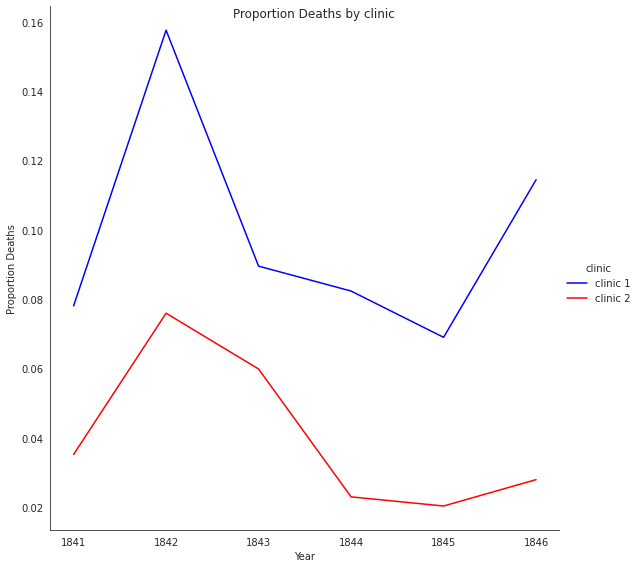

In [7]:
sns.set_style("white")
by_clinic = sns.relplot(
    data=df_2,
    kind="line",
    x="year",
    y="proportion_deaths",
    hue="clinic",
    height=8,
    palette=["b", "r"]
)

by_clinic.set_axis_labels(y_var="Proportion Deaths",
                          x_var="Year")
by_clinic.fig.suptitle("Proportion Deaths by clinic")

Text(0.5, 0.98, 'Effect of mandatory handwashing on proportion deaths')

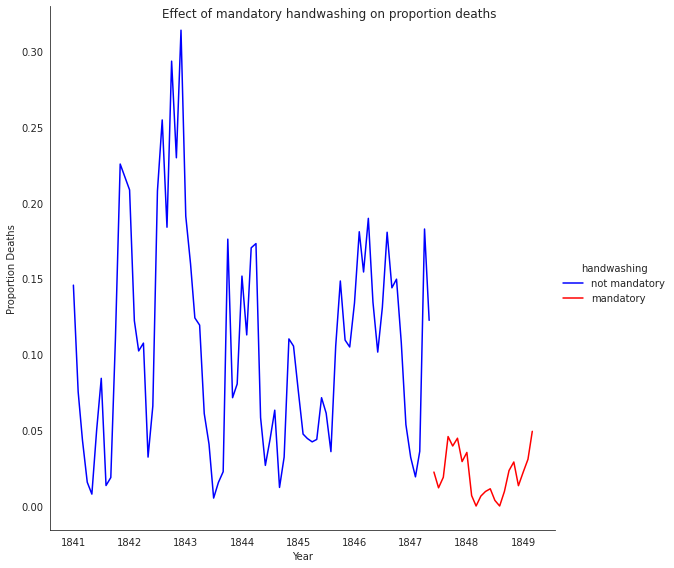

In [8]:
sns.set_style("white")
by_hwm = sns.relplot(
    data=df_1,
    kind="line",
    x="date",
    y="proportion_deaths",
    hue="handwashing",
    height=8,
    palette=["b", "r"]
)

by_hwm.set_axis_labels(y_var="Proportion Deaths",
                          x_var="Year")
by_hwm.fig.suptitle("Effect of mandatory handwashing on proportion deaths")

As we can see both graphs indicate that there is a difference in the proportion of deaths for: clinics and introduction of handwashing mandatory, respectively.

# Confidence Intervals for means

Since we are interested in the mean of the proportion of deaths, we can calculate confidence intervals for the mean.

$ \bar{x} \pm t\frac{s}{\sqrt{n}} $ 

where: $\bar{x}$ - sample mean, $t$ - the value of the chosen distribution with $n-1$ degrees of freedom (for small samples t-distribution, for large samples normal distribution), $s$ - sample standard deviation, $n$ - sample size

In Python $\frac{s}{\sqrt{n}}$ can be calculated manually as `(np.std(x, ddof=1)/np.sqrt(np.size(x)))` or usung the function `sem(x)` from *scipy.stats*

## According to the clinic

In [9]:
degreesFreedom_c1 = len(df_2[df_2["clinic"] == "clinic 1"])-1
degreesFreedom_c2 = len(df_2[df_2["clinic"] == "clinic 2"])-1
alpha = 0.95

clinic_1 = df_2.loc[df_2["clinic"] == "clinic 1", ["proportion_deaths"]]
clinic_2 = df_2.loc[df_2["clinic"] == "clinic 2", ["proportion_deaths"]]

ci_1 = st.t.interval(alpha=alpha, 
                     df=degreesFreedom_c1,
                     loc = np.mean(clinic_1),
                     scale = st.sem(clinic_1))

ci_2 = st.t.interval(alpha=alpha,
                     df=degreesFreedom_c2,
                     loc=np.mean(clinic_2),
                     scale=st.sem(clinic_2))

print("Confidence intervals for mean of proportion deaths in clinic 1:")
print("mean: ", np.mean(clinic_1))
print("Interval:", ci_1[0], " - ", ci_1[1])
print()
print("Confidence intervals for mean of proportion deaths in clinic 2:")
print("mean: ", np.mean(clinic_2))
print("Interval:", ci_2[0], " - ", ci_2[1])

Confidence intervals for mean of proportion deaths in clinic 1:
mean:  proportion_deaths    0.098505
dtype: float64
Interval: [0.06409911]  -  [0.13291143]

Confidence intervals for mean of proportion deaths in clinic 2:
mean:  proportion_deaths    0.0404
dtype: float64
Interval: [0.0167942]  -  [0.06400567]


> There is a 95% chance that the confidence interval of [0.064, 0.133] contains the true population mean of proportion deaths for clinic 1.

> There is a 95% chance that the confidence interval of [0.016, 0.064] contains the true population mean of proportion deaths for clinic 2.

Comparing the two sample means, it can be concluded that the proportion of deaths in the clinic where births were delivered by midwives was lower than in the clinic where births were also delivered by doctors and students.

In order to formulate a final judgment, an appropriate statistical test (*included in the next section*) must be performed.

## According to the mandatory hand washing

In [10]:
df_1.handwashing.value_counts()

not mandatory    76
mandatory        22
Name: handwashing, dtype: int64

Since we have less than 30 observations for mandatory handwashing we will use the t-distribution further on.

In [11]:
df_1.groupby("handwashing").proportion_deaths.mean()

handwashing
mandatory        0.021093
not mandatory    0.105050
Name: proportion_deaths, dtype: float64

In [12]:
degreesFreedom_mhwN = len(df_1[df_1["handwashing"] == "not mandatory"])-1
degreesFreedom_mhwY = len(df_1[df_1["handwashing"] == "mandatory"])-1
alpha = 0.95

handwashing_N = df_1.loc[df_1["handwashing"] == "not mandatory", ["proportion_deaths"]]
handwashing_Y = df_1.loc[df_1["handwashing"] == "mandatory", ["proportion_deaths"]]

ci_N = st.t.interval(alpha=alpha,
                     df=degreesFreedom_mhwN,
                     loc=np.mean(handwashing_N),
                     scale=st.sem(handwashing_N))

ci_Y = st.t.interval(alpha=alpha,
                     df=degreesFreedom_mhwY,
                     loc=np.mean(handwashing_Y),
                     scale=st.sem(handwashing_Y))

print("Confidence intervals for mean of proportion deaths for not mandatory handwashing:")
print("mean: ", np.mean(handwashing_N))
print("Interval:", ci_N[0], " - ", ci_N[1])
print()
print("Confidence intervals for mean of proportion deaths for mandatory handwashing:")
print("mean: ", np.mean(handwashing_Y))
print("Interval:", ci_Y[0], " - ", ci_Y[1])


Confidence intervals for mean of proportion deaths for not mandatory handwashing:
mean:  proportion_deaths    0.10505
dtype: float64
Interval: [0.08888773]  -  [0.12121224]

Confidence intervals for mean of proportion deaths for mandatory handwashing:
mean:  proportion_deaths    0.021093
dtype: float64
Interval: [0.01435474]  -  [0.02783201]


> There is a 95% chance that the confidence interval of [0.087, 0.122] contains the true population mean of proportion deaths for not mandatory handwashing time period.

> There is a 95% chance that the confidence interval of [0.014, 0.028] contains the true population mean of proportion deaths for mandatory handwashing time period.

By comparing the two sample means, it can be believed that the enforcement of mandatory handwashing significantly reduced the average death proportion.

In order to formulate a final judgment, an appropriate statistical test (*included in the next section*) must be performed.

# Hypothesis testing

...is a procedure that allows you to test your assumptions about the general population without conducting a full population survey.

In our case, we want to prove that the average death rate for the two study groups is statistically different. That is:
1. the mean proportion of deaths in clinic 1 and clinic 2 is significantly different,
2. the mean proportion of deaths before the enforcement of mandatory handwashing and after the enforcement of mandatory handwashing is significantly different.

Based on the Polish textbook "Przystępny kurs statystyki, Tom 1, StatSoft" (eng. *Accessible Course in Statistics, Volume 1, StatSoft*), the following hypothesis testing graph can be drawn.

<img src="https://i.imgur.com/yVVcIXJ.png">

Since I could not find the Cochran-Cox test as it is presented in the above mentioned publication, we can use the Welch's test. 

------

For those interested in the difference between the two tests, I have included the test statistic formula for the Welch's test and the Cochran-Cox test.

Welch's test: 

$W = \frac{m_{1}-m_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}}+\frac{s_{2}^{2}}{n_{2}}}}$

Cochran-Cox test: 

$CC =\frac{m_{1}-m_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}-1}+\frac{s_{2}^{2}}{n_{2}-1}}}$

where: $s^2$ - sample variance, $m$ - sample mean, $n$ - sample size.

*If anyone has found additional information on this then please comment.* 

## Assumption of normality of distribution

In [13]:
# H0 = the sample comes from a normal distribution.
# H1 = the sample is not coming from a normal distribution.
# alpha = 0.05

print("Clinic 1: ", shapiro(clinic_1))
print("Clinic 2: ", shapiro(clinic_2))
print("Not mandatory handwashing: ", shapiro(handwashing_N))
print("Mandatory handwashing: ", shapiro(handwashing_Y))

Clinic 1:  ShapiroResult(statistic=0.8554169535636902, pvalue=0.17398862540721893)
Clinic 2:  ShapiroResult(statistic=0.8636137843132019, pvalue=0.20191331207752228)
Not mandatory handwashing:  ShapiroResult(statistic=0.9461299180984497, pvalue=0.002843976253643632)
Mandatory handwashing:  ShapiroResult(statistic=0.9419049620628357, pvalue=0.21663230657577515)


For the data from both clinics, there are no reasons to reject the null hypothesis, so we can move on to testing for equality of variance.

Not mandatory handwashing has a p-value < $\alpha$, so to test the significance of the difference between the means we will use a non-parametric test.

## Assumption of equality of variances

In [14]:
# H0: the variances are equal across all samples/groups.
# H1: the variances are not equal across all samples/groups.
# alpha = 0.05

print(levene(clinic_1["proportion_deaths"], clinic_2["proportion_deaths"]))

LeveneResult(statistic=0.18473478000163876, pvalue=0.6764496182171921)


p-value > $\alpha$ therefore there is no reason to reject the null hypothesis. Assume that the variances in both samples are equal.

## Two Sample t-test

Assumptions:
+ The observations in one sample should be independent of the observations in the other sample.
+ The data should be approximately normally distributed.
+ The two samples should have approximately the same variance.

We met the above assumptions for the data regarding clinics.

> H0: the two population means are equal. <br />
> H1: the two population means are not equal. <br />
> $\alpha = 0.05$

In [15]:
print(ttest_ind(clinic_1, clinic_2, equal_var=True))

Ttest_indResult(statistic=array([3.5796971]), pvalue=array([0.00501423]))


because p-value < $\alpha$ we reject the null hypothesis in favor of the alternative hypothesis. This means that the mean proportion of deaths in clinic one and clinic two are significantly different from each other.

## Mann-Whitney U Test

The Mann-Whitney U test is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution. The test determines whether it is equally likely that any randomly selected observation from one sample will be greater or less than a sample in the other distribution [(Source)](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/). 

Since this is a non-parametric test, we do not need to meet any assumptions.

> H0: the sample distributions are equal. <br />
> H1: the sample distributions are not equal. <br />
> $\alpha = 0.05$

In [16]:
print(mannwhitneyu(handwashing_N, handwashing_Y))

MannwhitneyuResult(statistic=array([1505.]), pvalue=array([1.25602638e-08]))


Because p-value < alpha we reject the null hypothesis in favor of the alternative hypothesis. This means that the sample distribution for the period when handwashing was mandatory is different from the one when it wasn't.

# Conclusions

Based on both statistical tests and the estimation of the mean with confidence intervals, it can be concluded with certainty that:

1. In the clinic where only midwives delivered, the percentage of deaths due to puerperal fever is significantly lower than in the clinic where doctors and students also delivered.
2. The percentage of deaths in Doctor Semmelweis' clinic significantly decreased after the introduction of mandatory hand washing.